In [3]:
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)


from ema_workbench import (Model, MultiprocessingEvaluator,
                           ScalarOutcome, IntegerParameter, optimize, Scenario)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)

    model, steps = get_model_for_problem_formulation(2)

    reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'discount rate 0': 3.5, 'discount rate 1': 3.5,
                        'discount rate 2': 3.5,
                        'ID flood wave shape': 4}
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split('_')

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario('reference', **scen1)

In [5]:
convergence_metrics = [EpsilonProgress()]

espilon = [1e3] * len(model.outcomes)
nfe = 200 # proof of principle only, way to low for actual use

In [6]:
  with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=espilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/200 nfe
[MainProcess/INFO] optimization completed, found 15 solutions
[MainProcess/INFO] terminating pool


In [7]:
results.head()

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0        1        0        1        1        1        1        1        0   
1        1        0        1        0        1        0        0        0   
2        0        1        1        0        0        0        0        1   
3        1        0        0        0        0        0        0        1   
4        0        0        0        0        0        0        0        1   

   2_RfR 2  3_RfR 0  ...  A.4_DikeIncrease 1  A.4_DikeIncrease 2  \
0        0        1  ...                   6                   9   
1        1        0  ...                  10                   0   
2        0        1  ...                   7                   2   
3        0        1  ...                   3                   0   
4        1        0  ...                  10                   8   

   A.5_DikeIncrease 0  A.5_DikeIncrease 1  A.5_DikeIncrease 2  \
0                   1                   5                   0   
1                   9                   3                   7   
2                   0                   4                   1   
3                   0                   4                   9   
4                   4                   3                   3   

   Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
0            0.000000e+00           5.051027e+08          1.729100e+09   
1            0.000000e+00           6.277068e+08          5.389000e+08   
2            1.350716e+07           4.478248e+08          8.333000e+08   
3            2.268484e+07           4.543946e+08          4.926000e+08   
4            0.000000e+00           6.788330e+08          3.038000e+08   

   Evacuation Costs  Expected Number of Deaths  
0          0.000000                   0.000000  
1          0.000000                   0.000000  
2        925.397186                   0.001834  
3          0.000000                   0.025198  
4          0.000000                   0.000000  

[5 rows x 36 columns]

In [8]:
outcomes = results.loc[:, ['A.5_DikeIncrease 0','Expected Annual Damage','Dike Investment Costs']]

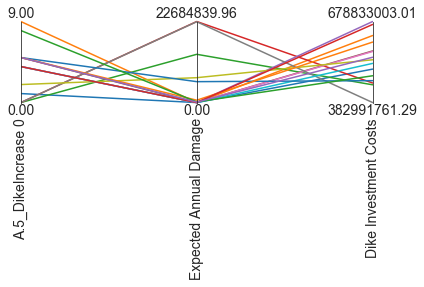

In [9]:
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

AttributeError: 'DataFrame' object has no attribute 'hypervolume'

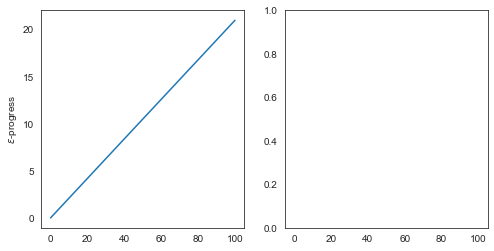

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()